# Loss Experiment

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

from src.models import MLP
from src.models import train
from src.utils import init_dataloader
from src.calc import LossCalculator
from src.visualize import LossVisualizer
from src.directions_eigen import MaxEigenvector

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = init_dataloader(
    dataset_name='MNIST',
    transform=transform,
    batch_size=64,
    dataset_load_path='data/',
    train_mode=True,
    size=64 * (10000 // 64)
)

test_loader = init_dataloader(
    dataset_name='MNIST',
    transform=transform,
    batch_size=64,
    dataset_load_path='data/',
    train_mode=False,
    size=64 * (10000 // 64)
)

In [3]:
model = MLP(layers_num=2, hidden=256, input_channels=1, input_sizes=(28, 28), classes=10).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train(model, criterion, train_loader, optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
core = MaxEigenvector(model, criterion, train_loader)
calc = LossCalculator(model, criterion, train_loader, core)
vis = LossVisualizer(calc)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

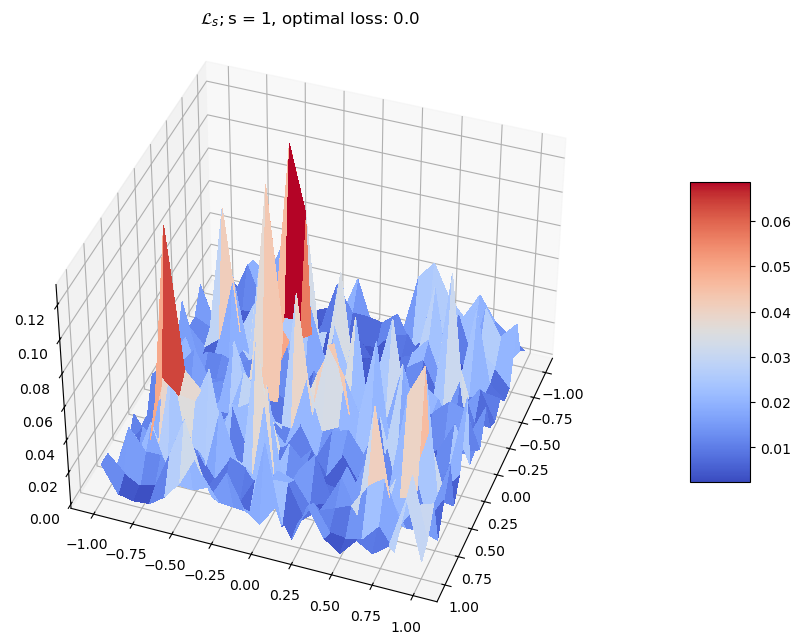

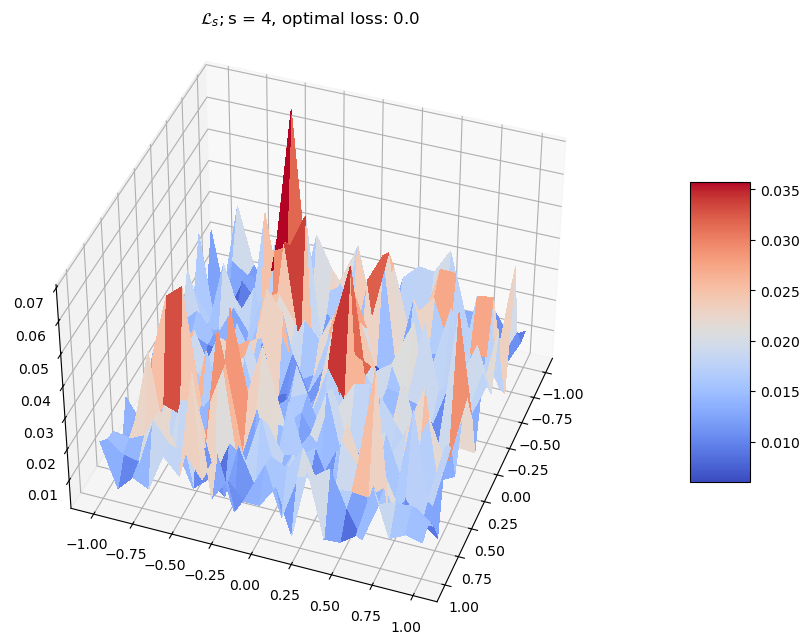

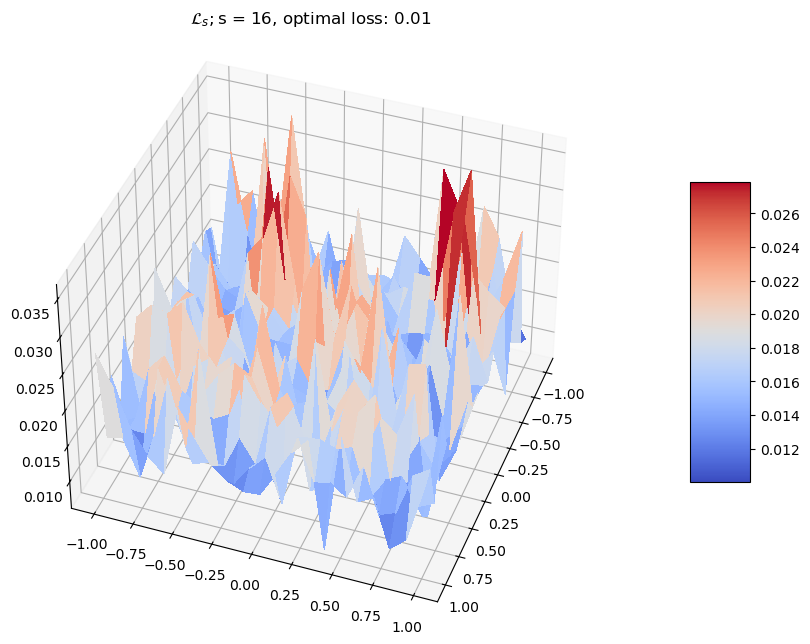

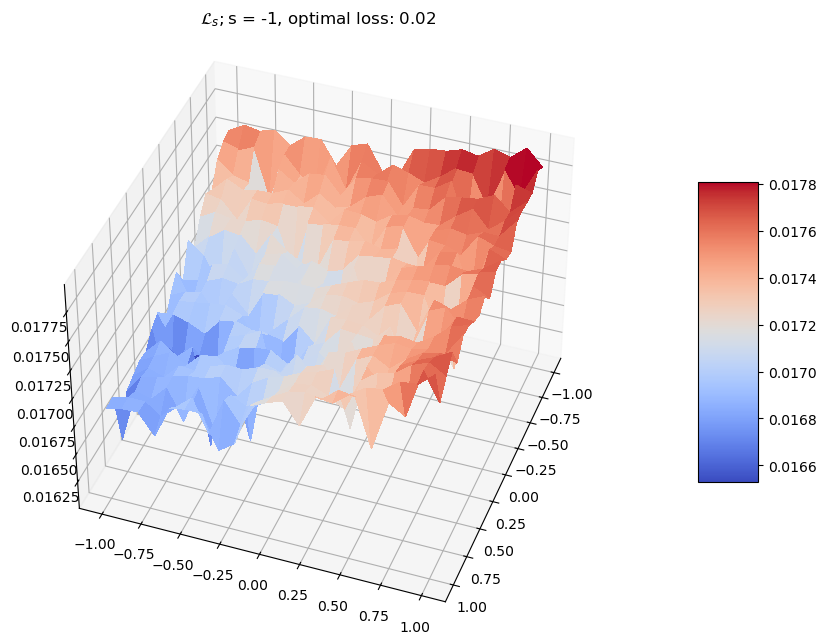

In [5]:
vis.visualize(size=1)
vis.visualize(size=4)
vis.visualize(size=16)
vis.visualize(size=-1)

In [5]:
import torch


# Функция для получения потерь на батче
def get_loss(model, inputs, targets, criterion):
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    return loss


# Функция для вычисления произведения гессиана на вектор (HVP)


# Метод степенной итерации с учетом дефляции по нескольким векторам
def power_iteration(loss, model, num_iters=100, tol=1e-6, device=None, deflation_vecs=None):
    # Определяем размерность вектора параметров модели
    params = list(model.parameters())
    flat_params = torch.cat([p.view(-1) for p in params])
    n = flat_params.shape[0]
    if device is None:
        device = flat_params.device

    # Инициализируем случайный вектор
    v = torch.randn(n, device=device)
    v = v / v.norm()
    eigenvalue = None
    for i in range(num_iters):
        hv = hvp(loss, model, v)
        # Если заданы векторы для дефляции, удаляем их вклад
        if deflation_vecs is not None:
            for d in deflation_vecs:
                hv = hv - torch.dot(hv, d) * d
        new_v = hv / hv.norm()
        eigenvalue = torch.dot(new_v, hv)
        if torch.norm(new_v - v) < tol:
            break
        v = new_v
    return eigenvalue, v


# Функция для вычисления k наибольших собственных значений и собственных векторов
def get_top_k_eigens(loss, model, k, num_iters=100, tol=1e-6, device=None):
    eigenvalues = []
    eigenvectors = []
    for i in range(k):
        # Передаем ранее найденные векторы для дефляции, если они есть
        eigenvalue, eigenvector = power_iteration(
            loss, model, num_iters=num_iters, tol=tol, device=device,
            deflation_vecs=eigenvectors if eigenvectors else None
        )
        eigenvalues.append(eigenvalue)
        eigenvectors.append(eigenvector)
    return eigenvalues, eigenvectors


# Пример использования:
# Предположим, что train_loader, valid_loss, model, criterion и DEVICE определены
inputs, targets = next(iter(train_loader))
inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

loss = valid_loss(model, criterion, train_loader, device=DEVICE)

k = 5  # Например, получим 2 наибольших собственных вектора
eigenvalues, eigenvectors = get_top_k_eigens(loss, model, k=k, num_iters=100, device=DEVICE)

for i in range(k):
    print(f"{i + 1}-ое собственное значение:", eigenvalues[i].item())


NameError: name 'hvp' is not defined

In [6]:
import torch


# Функция для получения потерь на батче
def get_loss(model, inputs, targets, criterion):
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    return loss


# Функция для вычисления произведения гессиана на вектор (HVP)
def hvp(loss, model, v):
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    flat_grad = torch.cat([g.contiguous().view(-1) for g in grads])
    grad_v = torch.dot(flat_grad, v)
    hv = torch.autograd.grad(grad_v, model.parameters(), retain_graph=True)
    hv_flat = torch.cat([h.contiguous().view(-1) for h in hv])
    return hv_flat


# Метод степенной итерации для нахождения собственного вектора гессиана
def power_iteration(loss, model, num_iters=100, tol=1e-6, device=None, deflation_vec=None):
    # Получаем размерность вектора параметров модели
    params = list(model.parameters())
    flat_params = torch.cat([p.view(-1) for p in params])
    n = flat_params.shape[0]
    if device is None:
        device = flat_params.device

    v = torch.randn(n, device=device)
    v = v / v.norm()
    eigenvalue = None
    for i in range(num_iters):

        hv = hvp(loss, model, v)
        if deflation_vec is not None:
            hv = hv - torch.dot(hv, deflation_vec) * deflation_vec
        new_v = hv / hv.norm()
        eigenvalue = torch.dot(new_v, hv)
        if torch.norm(new_v - v) < tol:
            break
        v = new_v
    return eigenvalue, v


inputs, targets = next(iter(train_loader))
inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

loss = valid_loss(model, criterion, train_loader, device=DEVICE)

eigenvalue1, eigenvector1 = power_iteration(loss, model, num_iters=100, device=DEVICE)
print("Первое собственное значение:", eigenvalue1.item())

eigenvalue2, eigenvector2 = power_iteration(loss, model, num_iters=100, device=DEVICE, deflation_vec=eigenvector1)

print("Второе собственное значение:", eigenvalue2.item())

Первое собственное значение: 5.487927436828613
Второе собственное значение: 4.73452615737915


In [ ]:
vis = LossVisualizer(model, train_loader, criterion, LossEigenCalculator, grid_step=0.1, direction_norm=10)

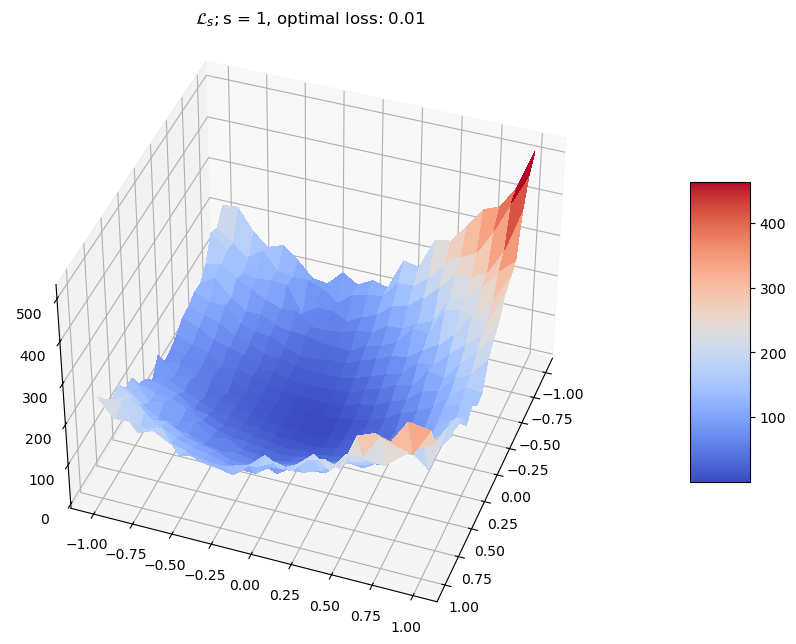

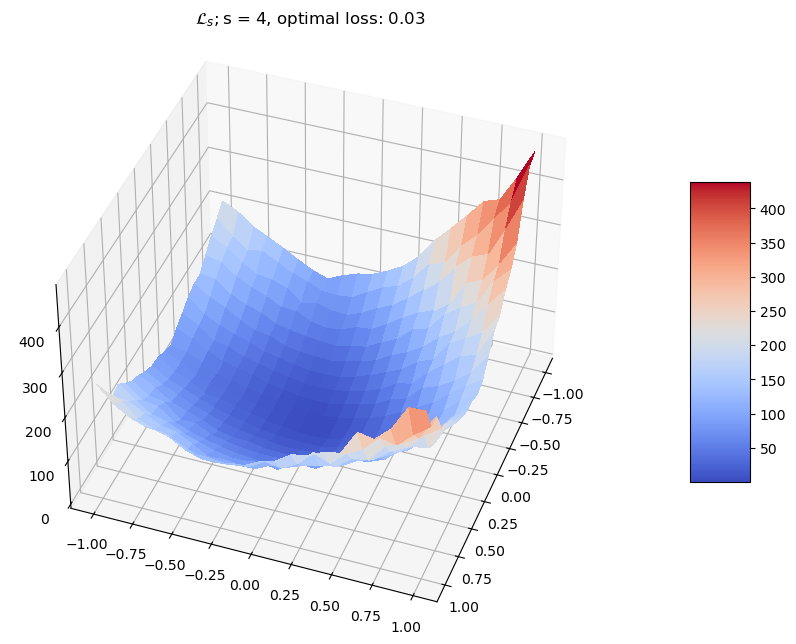

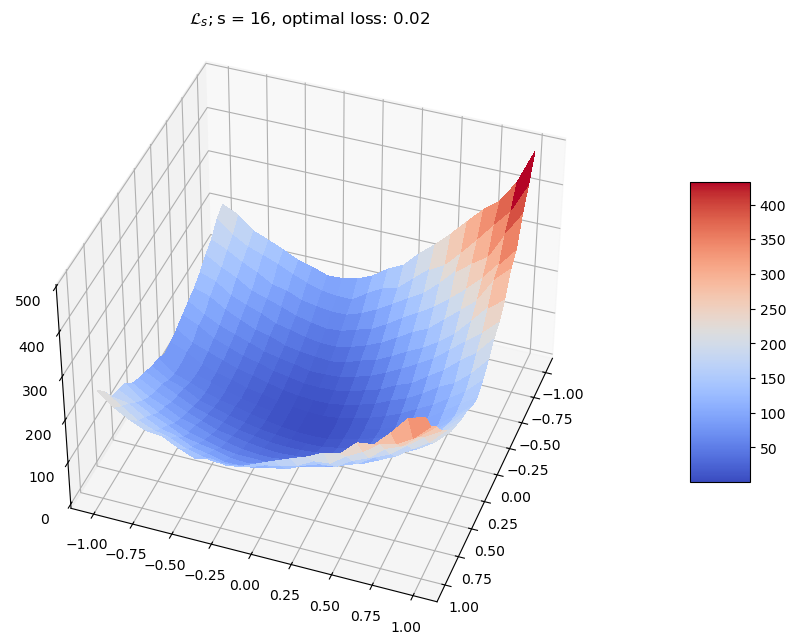

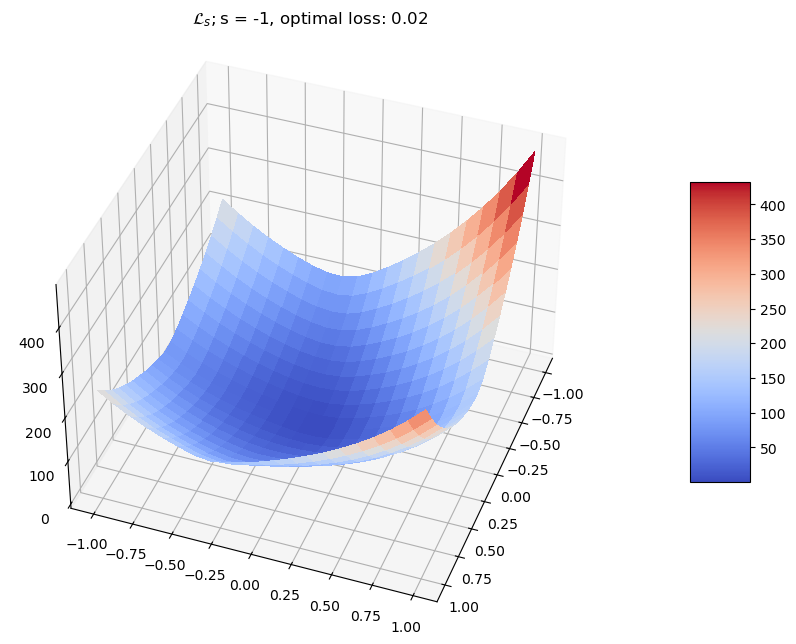

In [5]:
vis.visualize(size=1)
vis.visualize(size=4)
vis.visualize(size=16)
vis.visualize(size=-1)

/home/ntheme/Data1/Workfiles/Programming/Projects/MIPT/Machine Learning/Intelligent Systems/2025-Project-183/code/src/visualize.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


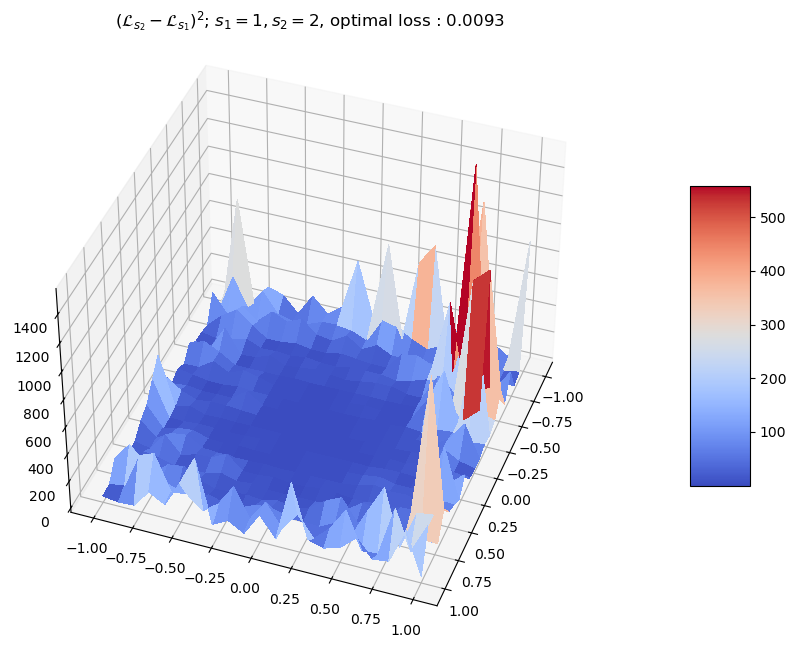

/home/ntheme/Data1/Workfiles/Programming/Projects/MIPT/Machine Learning/Intelligent Systems/2025-Project-183/code/src/visualize.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


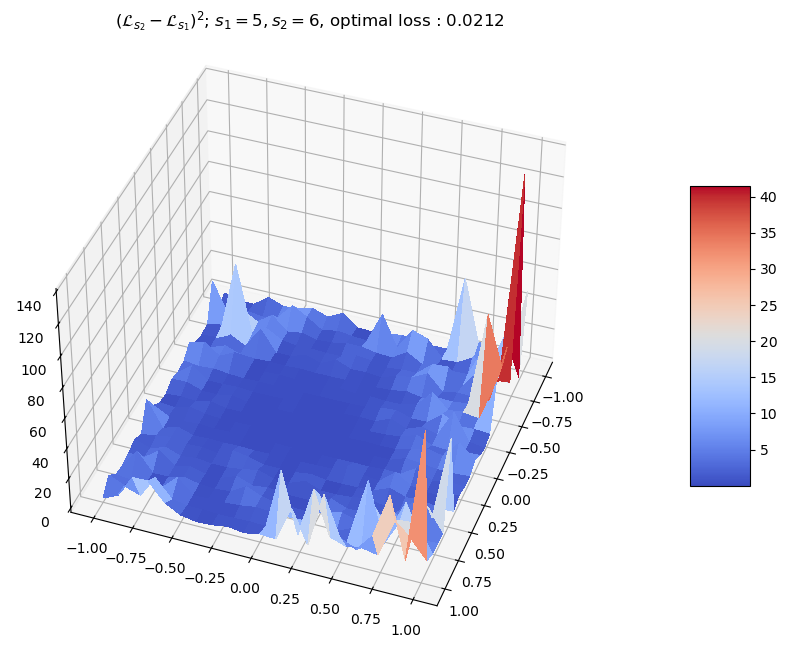

/home/ntheme/Data1/Workfiles/Programming/Projects/MIPT/Machine Learning/Intelligent Systems/2025-Project-183/code/src/visualize.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


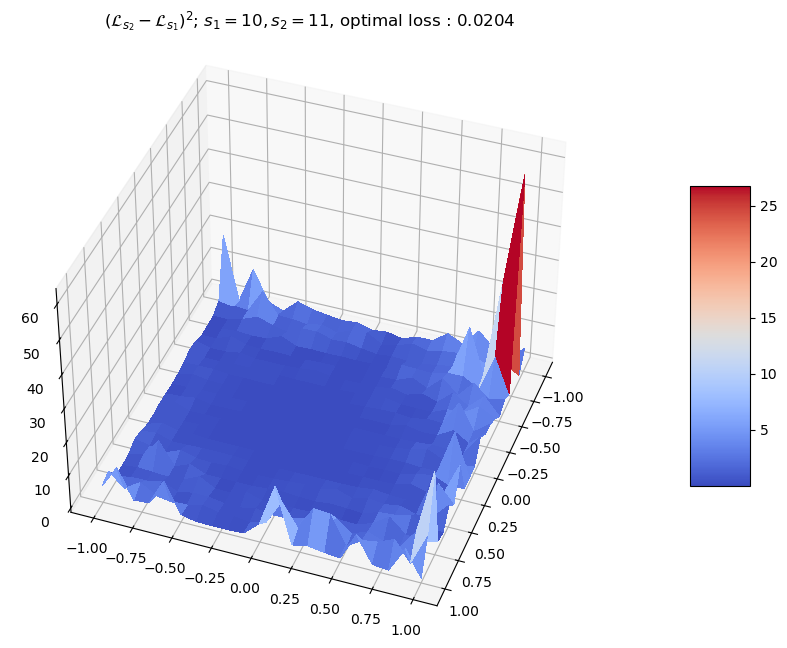

/home/ntheme/Data1/Workfiles/Programming/Projects/MIPT/Machine Learning/Intelligent Systems/2025-Project-183/code/src/visualize.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


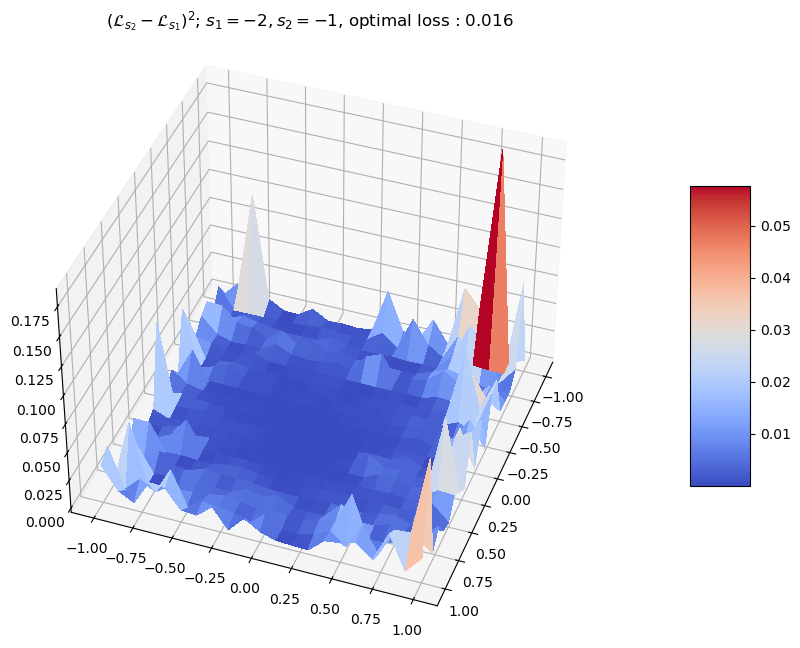

In [6]:
vis.visualize_diff(size1=1, size2=2, diff_type='square')
vis.visualize_diff(size1=5, size2=6, diff_type='square')
vis.visualize_diff(size1=10, size2=11, diff_type='square')
vis.visualize_diff(size1=-2, size2=-1, diff_type='square')

/home/ntheme/Data1/Workfiles/Programming/Projects/MIPT/Machine Learning/Intelligent Systems/2025-Project-183/code/src/visualize.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


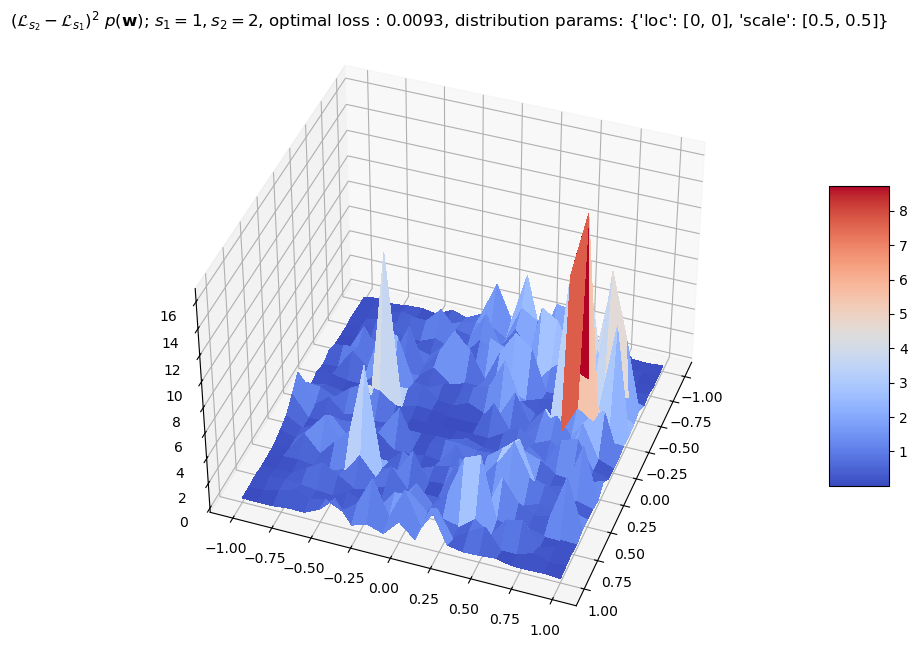

/home/ntheme/Data1/Workfiles/Programming/Projects/MIPT/Machine Learning/Intelligent Systems/2025-Project-183/code/src/visualize.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


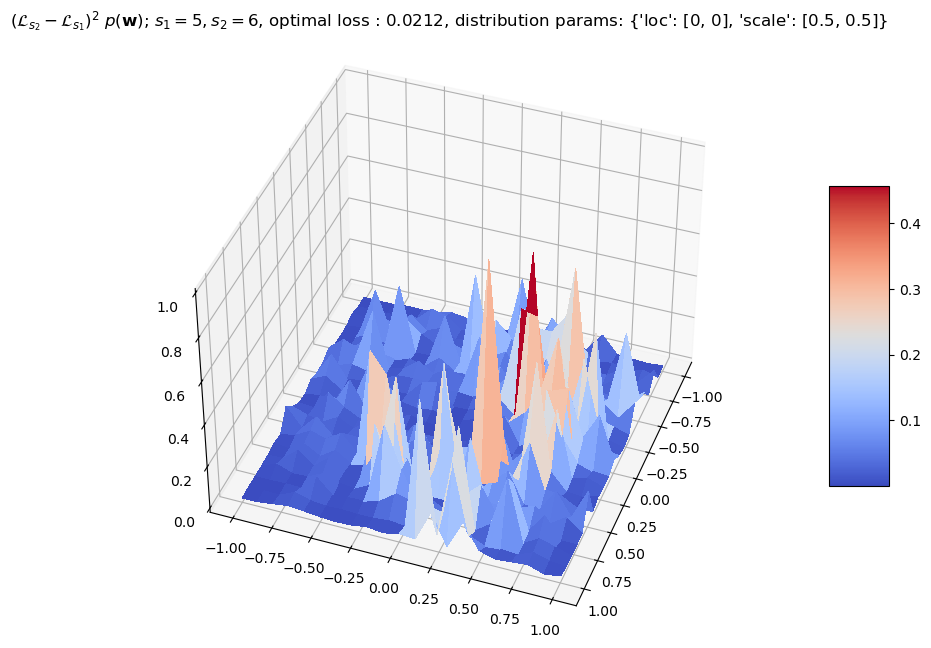

/home/ntheme/Data1/Workfiles/Programming/Projects/MIPT/Machine Learning/Intelligent Systems/2025-Project-183/code/src/visualize.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


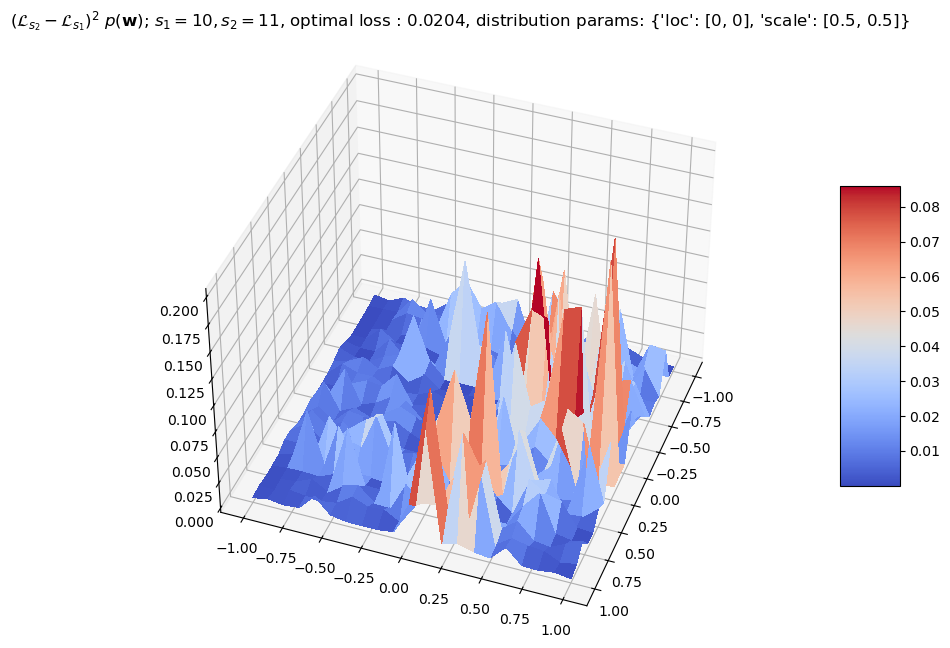

/home/ntheme/Data1/Workfiles/Programming/Projects/MIPT/Machine Learning/Intelligent Systems/2025-Project-183/code/src/visualize.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


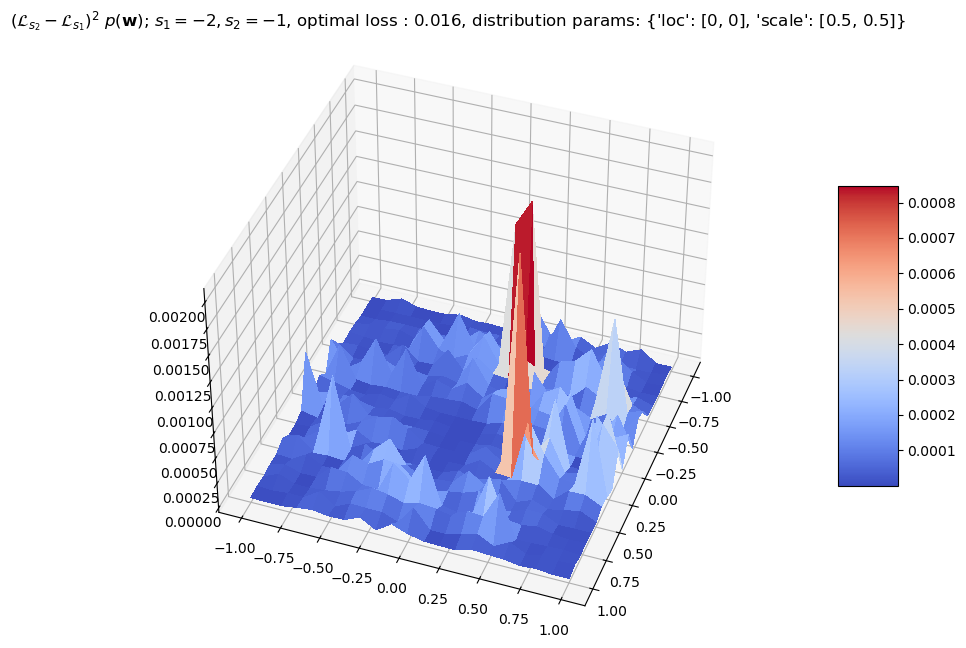

In [7]:
vis.visualize_diff(size1=1, size2=2,
                   diff_type='square_dot_normal',
                   distrib_params={'loc': [0, 0], 'scale': [0.5, 0.5]})
vis.visualize_diff(size1=5, size2=6,
                   diff_type='square_dot_normal',
                   distrib_params={'loc': [0, 0], 'scale': [0.5, 0.5]})
vis.visualize_diff(size1=10, size2=11,
                   diff_type='square_dot_normal',
                   distrib_params={'loc': [0, 0], 'scale': [0.5, 0.5]})
vis.visualize_diff(size1=-2, size2=-1,
                   diff_type='square_dot_normal',
                   distrib_params={'loc': [0, 0], 'scale': [0.5, 0.5]})